### Import python packages

In [58]:
import os
import numpy as np
import pandas as pd
import biotite.structure.io as strucio
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

### Get the average pLDDT score for each predicted structure

In [59]:
def get_plddt(directory):
    """
    Calculate the average pLDDT score for each structure in the directory.

    Parameters
    ----------
    directory : str
        The directory containing the PDB files.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the filename and average pLDDT score of each structure.
    """

    # List to store average B-factors
    avg_bfactors = []
    # Loop through each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".pdb"):
            filepath = os.path.join(directory, filename)

            # Load the structure
            test = strucio.load_structure(filepath, extra_fields=["b_factor"])

            # Extract B-factors and convert to list
            bfactor = test.b_factor[0::].tolist()

            # Calculate average B-factor
            avg_bfactor = sum(bfactor) / len(bfactor)

            # Store the result
            avg_bfactors.append((filename, avg_bfactor, bfactor))

    return pd.DataFrame(avg_bfactors, columns=["Filename", "Average pLDDT", "per-residue pLDDT"])

def plddt_hist(column,
              xlabel="value",
              ylabel="count",
              title="Title"):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Add background patches
    # Confidence levels for pLDDT scores
    # Very Low: 0-50, Low: 50-70, high: 70-90, Very High: 90-100
    alpha = 0.7
    ymax = 1.0  # End at 100% of the y-axis
    ymin = 0.91  # Start at 91% of the y-axis
    ax.axvspan(0, 50, color="#ff7d45", alpha=alpha, ymin=ymin, ymax=ymax)
    ax.axvspan(50, 70, color='#ffdb13', alpha=alpha, ymin=ymin, ymax=ymax)
    ax.axvspan(70, 90, color='#65cbf3', alpha=alpha, ymin=ymin, ymax=ymax)
    ax.axvspan(90, 100, color='#0053d6', alpha=alpha, ymin=ymin, ymax=ymax)

    # Plot histogram with specified range and bin size
    n, bins, patches = ax.hist(column,
                            color="black",
                            range=(0, 100),
                            bins=50)

    max_structs = max(n)
    ax.set_ylim(0, max_structs + 0.10 * max_structs)

    # Add labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Create custom legend
    legend_patches = [
        Patch(color='#0053d6', label="Very High (90-100)"),
        Patch(color='#65cbf3', label="High (70-90)"),
        Patch(color='#ffdb13', label="Low (50-70)"),
        Patch(color="#ff7d45", label="Very Low (0-50)")
    ]
    ax.legend(handles=legend_patches,
            loc='upper left',
            bbox_to_anchor=(1, 1),
            title="pLDDT Confidence Levels")

    # Show plot
    plt.show()

### Plot histogram of pLDDT scores

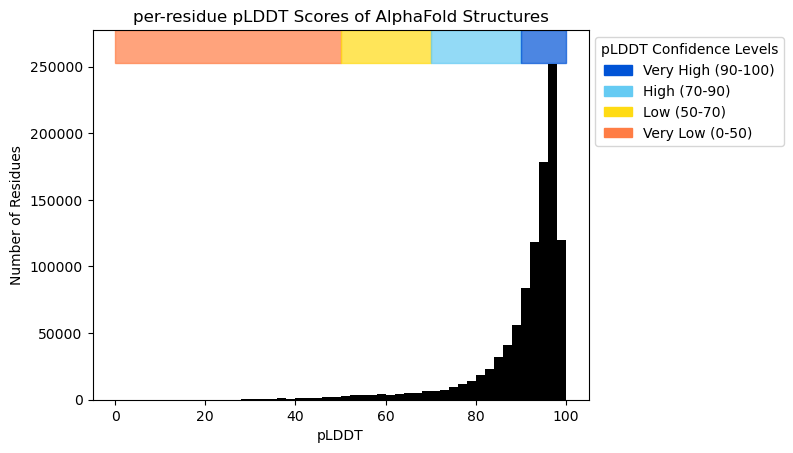

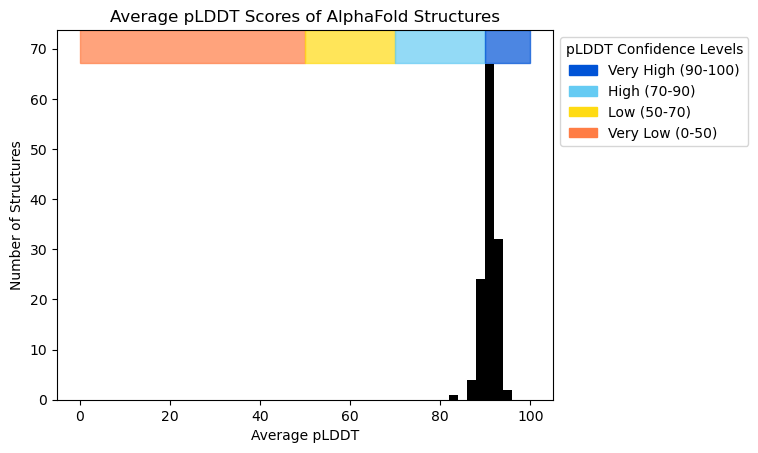

In [60]:
avg_plddt = get_plddt("Alphafold/alphafold_structures")
    

plddt_hist(np.concatenate(avg_plddt["per-residue pLDDT"].values),
          xlabel="pLDDT",
          ylabel="Number of Residues",
          title="per-residue pLDDT Scores of AlphaFold Structures")

plddt_hist(avg_plddt["Average pLDDT"],
          xlabel="Average pLDDT", 
          ylabel="Number of Structures",
          title="Average pLDDT Scores of AlphaFold Structures")


### Plot foldseek and mmseq clustering

In [61]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Add the directory to sys.path
sys.path.append(os.path.abspath('../pyMCL'))

# Import the module
from pyMCL import markov_cluster

def avg_reflected_hits(df):
    # Sort query and target to ensure A->B is the same as B->A
    df['query-target'] = df.apply(lambda x: tuple(sorted((x['query'], x['target']))), axis=1)

    # Select only numeric columns for averaging
    numeric_columns = df.select_dtypes(include='number').columns

    # Group by query-target and calculate the mean of all numeric columns
    avg_reflected = df.groupby('query-target')[numeric_columns].mean().reset_index()

    # Separate query and target
    avg_reflected[['query', 'target']] = pd.DataFrame(avg_reflected['query-target'].tolist(), index=avg_reflected.index)

    # Drop the query-target column
    avg_reflected.drop(columns='query-target', inplace=True)

    # flip the query and target columns
    avg_reflected_flipped = avg_reflected.copy()
    avg_reflected_flipped['query'] = avg_reflected['target']
    avg_reflected_flipped['target'] = avg_reflected['query']

    # Combine the original and flipped dataframes
    avg_reflected = pd.concat([avg_reflected, avg_reflected_flipped])

    # Drop duplicates
    avg_reflected = avg_reflected.drop_duplicates(subset=['query', 'target'])

    # move query and target columns to the front
    cols = avg_reflected.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    avg_reflected = avg_reflected[cols]

    return avg_reflected


# Function to plot histogram
def plot_histogram(data, column, ax, title):
    ax.hist(data, color="black", bins=50)
    ax.set_xlabel(column)
    ax.set_ylabel("Number of pairs")
    ax.set_title(title)

# Function to plot number of clusters vs inflation value
def plot_clusters_vs_inflation(df, ax):
    # Plot clusters vs. inflation for both bitscore and evalue
    def plot_metric(df, label):
        cluster_counts = []
        for inflation in range(2, 150, 1):
            clusters = markov_cluster(df, inflation=inflation)
            cluster_counts.append((len(clusters), inflation))
        cluster_counts_df = pd.DataFrame(cluster_counts, columns=["Number of clusters", "Inflation value"])
        ax.plot(cluster_counts_df['Inflation value'], cluster_counts_df['Number of clusters'], label=label)

    # Plot for bits
    plot_metric(df[['query', 'target', 'bits']],'Bits Score')
    # Plot for evalue
    plot_metric(df[['query', 'target', 'evalue']],'E-value')

    ax.set_xlabel("Inflation value")
    ax.set_ylabel("Number of clusters")
    ax.set_title("Clusters vs Inflation")
    ax.legend()


def plot_grid(mmseqs, foldseek):
    # Convert evalue to -log10(evalue)
    def convert_evalue(df):
        df['evalue'] = -np.log10(df['evalue'])
        df['evalue'] = df['evalue'].apply(lambda x: 300 if x > 300 else x)
    
    convert_evalue(mmseqs)
    convert_evalue(foldseek)

    fig, axs = plt.subplots(3, 2, figsize=(10, 8))

    # Row 1: Bitscore histogram
    plot_histogram(foldseek['bits'], 'bits', axs[0, 0], 'Foldseek Bits Score Histogram')
    plot_histogram(mmseqs['bits'], 'bits', axs[0, 1], 'MMseqs Bits Score Histogram')

    # Row 2: E-value histogram
    plot_histogram(foldseek['evalue'], '-log(evalue)', axs[1, 0], 'Foldseek -log(evalue) Histogram')
    plot_histogram(mmseqs['evalue'], '-log(evalue)', axs[1, 1], 'MMseqs -log(evalue) Histogram')

    # Row 3: Clusters vs Inflation
    plot_clusters_vs_inflation(foldseek, axs[2, 0])
    axs[2, 0].set_title('Foldseek: Clusters vs Inflation')

    plot_clusters_vs_inflation(mmseqs, axs[2, 1])
    axs[2, 1].set_title('MMseqs: Clusters vs Inflation')

    plt.tight_layout()
    plt.show()

/home/cahoonlab/miniconda3/envs/busta/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/cahoonlab/Documents/git_repositories/pyMCL/pyMCL/pymcl.py:93: UserWarning: Overlapping clusters detected and automatically resolved.
  clusters = _resolve_overlapping_clusters(clusters,
/home/cahoonlab/Documents/git_repositories/pyMCL/pyMCL/pymcl.py:93: UserWarning: Overlapping clusters detected and automatically resolved.
  clusters = _resolve_overlapping_clusters(clusters,
/home/cahoonlab/Documents/git_repositories/pyMCL/pyMCL/pymcl.py:93: UserWarning: Overlapping clusters detected and automatically resolved.
  clusters = _resolve_overlapping_clusters(clusters,
/home/cahoonlab/Documents/git_repositories/pyMCL/pyMCL/pymcl.py:93: UserWarning: Overlapping clusters detected and automatically resolved.
  clusters = _resolve_overlapping_clusters(clusters,
/home/cahoonlab/Documents/git_

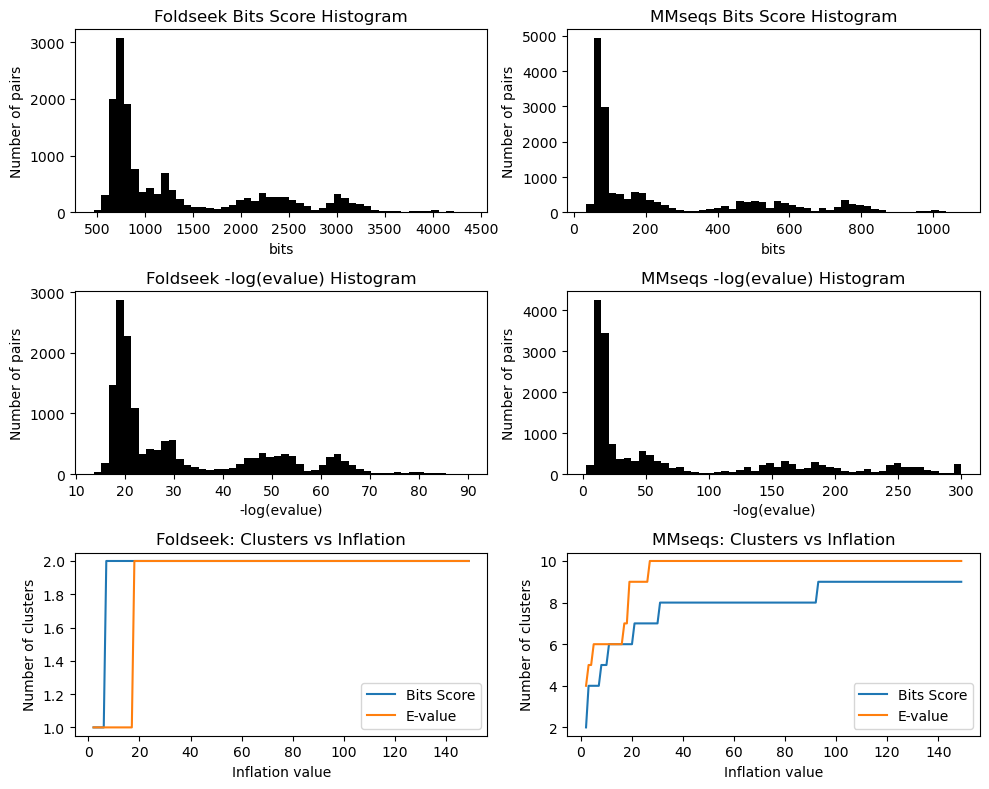

In [62]:
# Read TSV file
foldseek = pd.read_csv("foldseek/foldseek_results.tsv", sep="\t")
foldseek = foldseek[['query', 'target', 'bits', 'evalue', 'rmsd']]
foldseek = avg_reflected_hits(foldseek)
rmsd = foldseek[['query', 'target', 'rmsd']].pivot_table(index='query', columns='target', values='rmsd')

# mmseqs results
mmseqs = pd.read_csv("mmseqs/mmseqs_results.tsv", sep="\t")
mmseqs = mmseqs[['query', 'target', 'bits', 'evalue']]
mmseqs = avg_reflected_hits(mmseqs)

plot_grid(mmseqs, foldseek)


In [63]:
foldseek_clusters = markov_cluster(foldseek[['query', 'target', 'bits']], inflation=22)
mmseqs_clusters = markov_cluster(mmseqs[['query', 'target', 'evalue']], inflation=3)

In [64]:
# average rmsd columns
rmsd_avg = rmsd.mean(axis=0)

# filter rmsd for only pairs in clusters
rmsd_filtered = rmsd[rmsd.index.isin(mmseqs_clusters[0])]
rmsd_filtered = rmsd_filtered[[col for col in rmsd_filtered.columns if col in mmseqs_clusters[0]]]
rmsd_filtered_avg = rmsd_filtered.mean(axis=0)

In [2]:
import pandas as pd

def extract_mapping(data):
    # Initialize lists to store the extracted data
    search_id = []
    uniProtKB_ID = []
    taxonID = []
    interProIDs = []
    pantherFamilyIDs = []
    pantherSubfamilyIDs = []
    
    for entry in data['results']:
        # Append the basic fields
        search_id.append(entry['from'])
        uniProtKB_ID.append(entry['to']['uniProtkbId'])
        taxonID.append(entry['to']['organism']['taxonId'])
        
        # Extract InterPro IDs
        interPro_list = [ref['id'] for ref in entry['to']['uniProtKBCrossReferences'] if ref['database'] == 'InterPro']
        interProIDs.append(interPro_list)
        
        # Extract PANTHER Family and Subfamily IDs
        panther_family = []
        panther_subfamily = []
        for ref in entry['to']['uniProtKBCrossReferences']:
            if ref['database'] == 'PANTHER':
                if ':SF' in ref['id']:
                    panther_subfamily.append(ref['id'])
                else:
                    panther_family.append(ref['id'])
        
        # Ensure we align the family and subfamily correctly
        if len(panther_family) == 0:
            panther_family = [None] * len(panther_subfamily)
        if len(panther_subfamily) == 0:
            panther_subfamily = [None] * len(panther_family)
        
        pantherFamilyIDs.append(panther_family)
        pantherSubfamilyIDs.append(panther_subfamily)

    # Create a DataFrame
    df = pd.DataFrame({
        'From': search_id,
        'UniProtKB_ID': uniProtKB_ID,
        'taxonID': taxonID,
        'InterPro_IDs': interProIDs,
        'PANTHER_Family_IDs': pantherFamilyIDs,
        'PANTHER_Subfamily_IDs': pantherSubfamilyIDs
    })
    
    df['taxonID'] = df['taxonID'].astype(int)

    # Concatenate failed IDs and fill with NaN
    failed_ids = data.get('failedIds', [])
    if failed_ids:
        failed_df = pd.DataFrame(failed_ids, columns=['From'])
        df = pd.concat([df, failed_df], ignore_index=True)

    return df


In [52]:
import re
from typing import List

def filter_valid_uniprot_accessions(acc_numbers: List[str]) -> List[str]:
    # Define the regular expression pattern for UniProtKB accession numbers
    pattern = re.compile(
        r'^([OPQ][0-9][A-Z0-9]{3}[0-9]|'
        r'[A-NR-Z][0-9]([A-Z][A-Z0-9]{2}[0-9]){1,2})$'
    )
    
    valid_accessions = []
    for acc_number in acc_numbers:
        # Remove any .#[number] suffix
        base_acc_number = re.sub(r'\.\d+$', '', acc_number)
        # Check if the base accession number is valid
        if pattern.match(base_acc_number):
            valid_accessions.append(acc_number)
    
    return valid_accessions

filter_valid_uniprot_accessions(['Q9LVY7', "A0A3Q7HBJ5.1", "AEX07772"])

['Q9LVY7', 'A0A3Q7HBJ5.1']

In [44]:
import pandas as pd

mmseqs = pd.read_csv("mmseqs/mmseqs_results.tsv", sep="\t")
search_ids = mmseqs['query'].str.split('~').str[0]
search_ids = search_ids.drop_duplicates()
search_ids = search_ids.to_list()
search_ids = pd.Series(search_ids)

# serparate into databases

# refseq
refseq_nuc = search_ids[search_ids.str.contains('NM_')].to_list()
refseq_pro = search_ids[search_ids.str.contains('NP_')].to_list()

# remove refseq from search_ids
search_ids = search_ids[~search_ids.str.contains('NM_')]
search_ids = search_ids[~search_ids.str.contains('NP_')]

# swissprot entries are 6 characters long and start with P, Q, or O
import re
swissprot = [x for x in search_ids if re.match(r'^[PQK][A-Z0-9]{5}(\.\d+)?$', x)]

# UniProtKB/TrEMBL entries are 10 characters and start with A0A
uniprot_trembl = [x for x in search_ids if re.match(r'^A0A\w{7}(\.\d+)?$', x)]

# EMBL_cds if contains "."
embl_cds = [x for x in search_ids if '.' in x]

# EMBL everthing else
embl = search_ids[~search_ids.isin(embl_cds)].to_list()


In [41]:
from unipressed import IdMappingClient
import time
request = IdMappingClient.submit(
    source="EMBL-GenBank-DDBJ", dest="UniProtKB", ids=refseq_nuc
)

while True:
    status = request.get_status()
    if status in {"FINISHED", "ERROR"}:
        break
    else:
        time.sleep(3)

test = list(request.each_result())
print(test)

[{'from': 'NM_123623', 'to': 'Q9FH66'}, {'from': 'NM_001344756.1', 'to': 'Q8L7D5'}, {'from': 'NM_001344756.1', 'to': 'A0A178U980'}, {'from': 'NM_123002', 'to': 'Q9LVY7'}, {'from': 'NM_117621', 'to': 'Q0WQ07'}, {'from': 'NM_117621', 'to': 'A0A178V7C8'}, {'from': 'NM_124173', 'to': 'Q9FI39'}, {'from': 'NM_124173', 'to': 'A0A178UGC2'}, {'from': 'NM_001341032.1', 'to': 'A0A1P8B8J8'}, {'from': 'NM_001308937', 'to': 'A0A0A0LHC2'}, {'from': 'NM_180821', 'to': 'Q8L7D5'}, {'from': 'NM_180821', 'to': 'F4K051'}]


In [ ]:
mapping_df = extract_mapping(mapping)
mapping_cds_df = extract_mapping(mapping_cds)
mapping_self_df = extract_mapping(mapping_self)

def merge_dataframes(mapping_df, mapping_cds_df, mapping_self_df):
    # Concatenate the dataframes while ignoring the first row of the second and third dataframes
    merged_df = pd.concat([
        mapping_df,
        mapping_cds_df.iloc[1:],
        mapping_self_df.iloc[1:]
    ], ignore_index=True)
    
    return merged_df

final_mapping = merge_dataframes(mapping_df, mapping_cds_df, mapping_self_df)


merged_mapping = pd.merge(mapping_df, mapping_cds_df, on='From', how='outer', suffixes=('_df', '_cds'))

# Replace missing information for each column
for column in mapping_df.columns:
    if column != 'From':  # Skip the 'From' column as it's the key
        merged_mapping[column] = merged_mapping[f'{column}_df'].combine_first(merged_mapping[f'{column}_cds'])

# Drop the intermediate columns
columns_to_drop = [col for col in merged_mapping.columns if col.endswith('_df') or col.endswith('_cds')]
final_mapping = merged_mapping.drop(columns=columns_to_drop)

print(final_mapping)

In [22]:
from unipressed import UniprotkbClient
test = UniprotkbClient.fetch_many(["Q9FMA5", "O64697"])
